In [1]:
import numpy as np
import matplotlib.pyplot as plt

TODOs

- Want more than a two level heirarchy

In [2]:
n_actions = 16
n_states = 64
gamma = 0.999
H = 100  # number of time steps in a episode
K = 1000  # number of episodes

In [3]:
# utils
def onehot(idx, N):
    return np.eye(N)[idx]

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

In [4]:
class Env():
    def __init__(self, n_states, n_actions):
        self.S = np.arange(n_states)
        self.A = np.arange(n_actions)

        # model the transitions as linear fns conditional on the action.
        # P = np.random.standard_normal([n_actions, n_states, n_states]) **2 # make sharper

        # deterministic transition fn
        # each action move from state(i) to state(j) with probability 1.
        # BUG nope. softmax doesnt do this. will need to set to -infty
        self.P = 20*np.stack([np.random.permutation(np.eye(n_states, dtype=np.float32)) for _ in range(n_actions-1)] + [np.eye(n_states, dtype=np.float32)],axis=0)  
        # TODO what if there is structure in P? Low rank? Shared over actions?
        # QUESTION how does this parameterisation effect things?
        # NOTE this graph might be disconnected. but is unlikely!?

        # reward is only a fn of the current state - shape = [n_states]
        # also. is sparse.
        self.R = onehot(np.random.randint(0, n_states), n_states)

    def step(self, state, action):
        """
        A tabular, probabilistic step function. 

        Args:
            state (int): An element of S. The current state
            state (int): An element of A. The action to be taken

        Returns:
            new_state (int): An element of S.
        """
        # step by selecting relevant transition matrix and applying
        logits = np.matmul(self.P[action, ...], onehot(state, n_states))
        # convert to a distribution and sample
        new_s = np.random.choice(self.S, p=softmax(logits))
        return new_s, self.R[new_s]
    
    def rnd_policy(self, s, *args):
        return np.random.choice(self.A)
    
    def reset(self):
        return np.random.choice(self.S)


In [5]:
env = Env(n_states, n_actions)
env.step(0, env.rnd_policy(env.reset()))

(12, 0.0)

In [6]:
def sample(x, logits):
    # or could use gumbel trick
    p = softmax(logits)
    return np.random.choice(x, p=p)

In [74]:
class TabularQ():
    def __init__(self, n_states, n_actions):
        self.gamma = 0.999
        self.lr = 0.05

        self.qs = np.zeros([n_states, n_actions])
        
        self.old_s = None
        self.old_a = None
        self.old_r = None
    
    def __call__(self, s, r):
        a = sample(np.arange(n_actions), self.qs[s, ...])
        
        if self.old_s is not None:
            self.train_step(self.old_s, self.old_a, r, s, a)
                
        # loop past observations so we can use them for training
        self.old_s = s
        self.old_a = a
                
        return a
    
    def train_step(self, old_s, old_a, old_r, s, a):
        target = (old_r + self.gamma*self.qs[s, a])  # bootstrap off next step. TD!
        delta =  target - self.qs[old_s, old_a]
        self.qs[old_s, old_a] += self.lr * delta  # incremental update. exp avg/GD!

In [75]:
class TabularFuN():  # or HIRO!?
    # Tabular feudal network
    def __init__(self, n_states, n_actions):
        self.gamma = 0.9
        self.lr = 0.001

        self.qs = np.zeros([n_states, n_actions])
        
        self.old_s = None
        self.old_a = None
        self.old_r = None
    
    def __call__(self, s, r):
        a = sample(self.action_space, self.qs[s, ...])
        
        if self.old_s is not None:
            self.train_step(self.old_s, self.old_a, self.old_r, s, a)
                
        # loop past observations so we can use them for training
        self.old_s = s
        self.old_a = a
        self.old_r = r
                
        return a
    
    def train_step(self, old_s, old_a, old_r, s, a):
        target = (old_r + self.gamma*self.qs[s, a])  # bootstrap off next step. TD!
        delta =  target - self.qs[old_s, old_a]
        self.qs[old_s, old_a] += self.lr * delta  # incremental update. exp avg/GD!

In [76]:
class TabularHRIO():
    # Tabular feudal network
    def __init__(self, n_states, n_actions):
        self.gamma = 0.9
        self.lr = 0.001

        self.qs = np.zeros([n_states, n_actions])
        
        self.old_s = None
        self.old_a = None
        self.old_r = None
    
    def __call__(self, s, r):
        a = sample(self.action_space, self.qs[s, ...])
        
        if self.old_s is not None:
            self.train_step(self.old_s, self.old_a, self.old_r, s, a)
                
        # loop past observations so we can use them for training
        self.old_s = s
        self.old_a = a
        self.old_r = r
                
        return a
    
    def train_step(self, old_s, old_a, old_r, s, a):
        target = (old_r + self.gamma*self.qs[s, a])  # bootstrap off next step. TD!
        delta =  target - self.qs[old_s, old_a]
        self.qs[old_s, old_a] += self.lr * delta  # incremental update. exp avg/GD!

In [77]:
class TabularOpC():
    # Tabular option critic
    def __init__(self, n_states, n_options, n_actions):
        self.n_actions = n_actions
        self.n_options = n_options
        self.n_states = n_states
        self.gamma = 0.999
        self.lr = 0.05

        # hmm. viewing options as another dim seems weird?
        # so each option yields a different set of qs.
        self.qs = np.zeros([n_states, n_options, n_actions])
        self.term_probs = np.ones([n_states, n_options])
        self.term_probs /= np.sum(self.term_probs, axis=0)
        
        self.old_s = None
        self.old_a = None
        self.old_r = None
        
        self.w = np.random.randint(n_options)
    
    def __call__(self, s, r):
        # NOTE in the OpC paper they use a policy not the Q fn to take actions
        a = sample(np.arange(self.n_actions), self.qs[s, self.w, :])
        
        if self.old_s is not None:
            self.train_step(self.old_s, self.old_a, r, s, a)
                
        if self.term_probs[s, self.w] < np.random.random():
            self.w = sample(np.arange(n_options), self.q_omega(s))
                
        # loop past observations so we can use them for training
        self.old_s = s
        self.old_a = a
                
        return a
    
    def train_step(self, old_s, old_a, old_r, s, a):
        ### Qs
        # the option critic value estimate
        omega_s_tp1 = self.q_omega(s)
        next_state_value = ((1-self.term_probs[s, self.w]) * omega_s_tp1[self.w]
                           + self.term_probs[s, self.w] * np.max(omega_s_tp1))
        # bootstrap off next step. TD!
        target = old_r + self.gamma*next_state_value
        # estimate grad of MSBE
        delta =  target - self.qs[old_s, self.w, old_a]
        # incremental update. exp avg/GD!
        self.qs[old_s, self.w, old_a] += self.lr * delta  
        
        ### termination props
        # value_actual_w - value_best_w
        self.term_probs -= self.lr * (omega_s_tp1[self.w] - next_state_value)
        self.term_probs /= np.sum(self.term_probs, axis=0)
        # need to normalise these!?!?
        
        ### policy
        # none...
        pass
    
    def q_omega(self, s):
        # not sure how to do this with matrix ops
        # uhh, it slow...
        q_omega = np.zeros([self.n_options])
        for w in range(self.n_options):
            p = softmax(self.qs[s, w, :])
            q_omega[w] += np.dot(self.qs[s,w,:], p)
        return q_omega

would expect that heirarchical approaches will generalise more easily to other rewards/tasks!?
as they can transfer some of the options. 

In [78]:
def play_episode(env, player, len_episode):
    # reset
    s = env.reset()
    total_r = 0
    r = 0
    w = np.random.randint(8)
    
    # play an episode
    for _ in range(len_episode):
        a = player(s, r)
        s, r = env.step(s, a)
        total_r += r
        
    return total_r/len_episode

In [79]:
n_states=16
n_options=8
n_actions=8
env = Env(n_states, n_actions)

In [80]:
player = TabularOpC(n_states, n_options, n_actions)
opc_rs = [play_episode(env, player, 100) for _ in range(1000)]

In [81]:
player = TabularQ(n_states, n_actions)
q_rs = [play_episode(env, player, 100) for _ in range(1000)]

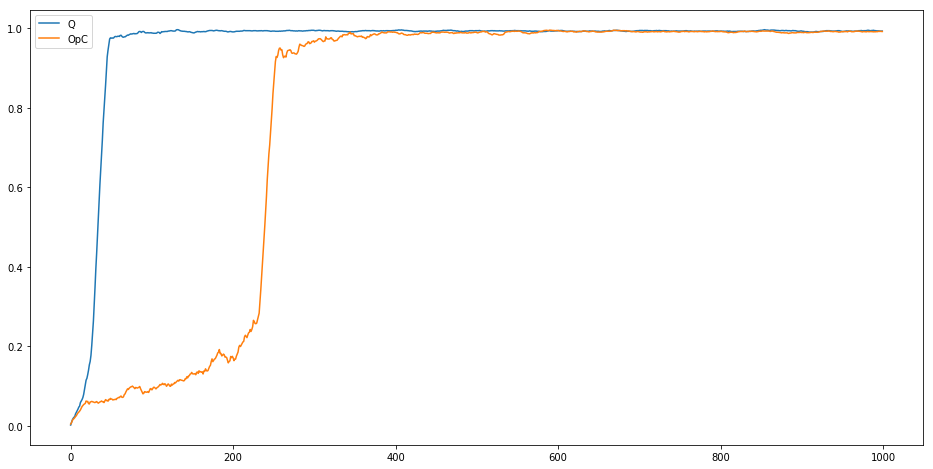

In [82]:
def plot(x, label):
    n = len(x)
    idx = range(n)
#     mean = np.mean(x)
#     stddev = np.sqrt(np.var(x))
    
    # smooth the signals
    n_kernel = 20
    kernel = [1]*n_kernel
    x = np.convolve(x, kernel)[:n]/n_kernel
#     stddev = np.convolve(stddev, kernel)[:n]/n_kernel
    
    # plot
    plt.plot(idx, x, label=label)
#     plt.fill_between(idx, mean-stddev, mean+stddev,  alpha=0.3)

plt.figure(figsize=(16, 8))
plot(q_rs, label='Q')
plot(opc_rs, label='OpC')
plt.legend()